## ROC 곡선 (Receiver Operating Characteristic Curve)과 AUC

ROC 곡선은 이진 분류 모델의 성능을 평가하는 중요한 시각적 도구이다. 모델의 분류 결정 임계값(Threshold)이 변함에 따라 '재현율(TPR)'과 '위양성률(FPR)'이 어떻게 변하는지를 하나의 곡선으로 나타낸다. 이를 통해 모델이 양성 클래스와 음성 클래스를 얼마나 잘 구별하는지 한눈에 파악할 수 있다.

### ROC 곡선의 핵심: 이득-비용 분석 차트

ROC 곡선을 **이득(Benefit)과 비용(Cost)의 관점**에서 심도 있게 분석함. 이 관점은 ROC 곡선의 본질을 이해하는 가장 효과적인 방법임.

ROC 곡선은 분류 모델의 성능을 단순히 '좋다/나쁘다'로 평가하는 것을 넘어, **"하나의 이득을 얻기 위해 얼마의 비용을 치러야 하는가?"**라는 근본적인 질문에 답하는 **이득-비용 분석 차트**라고 할 수 있음.

#### ROC 곡선의 두 축: 이득과 비용

**X축: 위양성률 (FPR, False Positive Rate) - '비용'**
- **정의**: 실제 `Negative`인 데이터 중에서 모델이 `Positive`로 잘못 예측한 비율
- **계산**: `FPR = FP / (FP + TN)` = **(1 - 특이도)**
- **의미**: 이득을 얻기 위해 감수해야 하는 대가 또는 위험. 암 진단 예시에서는 '정상인을 암 환자로 잘못 진단하여 불필요한 공포와 추가 검사를 유발하는 것'
- **목표**: **0에 가까울수록 좋음** (최소화해야 할 대상)

**Y축: 재현율 (TPR, True Positive Rate) - '이득'**
- **정의**: 실제 `Positive`인 데이터 중에서 모델이 `Positive`로 올바르게 예측한 비율
- **계산**: `TPR = TP / (TP + FN)` = **민감도(Sensitivity)** = **재현율(Recall)**
- **의미**: 모델의 주된 목표. 암 진단에서는 '실제 암 환자를 한 명이라도 더 정확하게 찾아내는 것'
- **목표**: **1에 가까울수록 좋음** (최대화해야 할 대상)

#### 이득과 비용의 상충 관계 (Trade-off)

현실 세계의 어떤 모델도 비용 없이 이득만 100% 취할 수는 없음. 이 둘은 **상충 관계(Trade-off)**에 있음.

- **이득을 높이려고 하면** (임계값 ↓):
  - 실제 양성을 더 많이 찾아냄 (TPR ↑, **이득 증가**)
  - 동시에 음성을 양성으로 오진하는 경우도 증가 (FPR ↑, **비용 증가**)

- **비용을 낮추려고 하면** (임계값 ↑):
  - 오진은 줄어들지만 (FPR ↓, **비용 감소**)
  - 실제 양성을 놓칠 가능성 증가 (TPR ↓, **이득 감소**)

#### 모델 성능 해석

1. **완벽한 모델**: 좌상단 **(0, 1)** - 비용 0, 이득 1
2. **좋은 모델**: 좌상단에 가까운 곡선 - 효율적인 이득 창출
3. **무작위 분류기**: 대각선 **y=x** - 이득과 비용이 정비례 (AUC=0.5)

### 예시 데이터 준비

ROC 곡선을 그리려면, 모델이 각 데이터에 대해 '양성(Positive)일 확률'을 예측한 값이 필요하다.

In [1]:
# 기본 라이브러리 설정
import numpy as np
import matplotlib.pyplot as plt

# 예시 데이터
# y_true: 실제 정답 값
y_true = np.array([0, 0, 0, 0, 1, 1, 1, 1])

# y_scores: 모델이 예측한 '양성(1)일 확률'
y_scores = np.array([0.1, 0.2, 0.7, 0.8, 0.3, 0.5, 0.6, 0.9])

print("실제 값:", y_true)
print("모델 예측 확률:", y_scores)

실제 값: [0 0 0 0 1 1 1 1]
모델 예측 확률: [0.1 0.2 0.7 0.8 0.3 0.5 0.6 0.9]


### ROC 곡선 직접 계산 및 시각화

분류 기준이 되는 임계값(Threshold)을 0부터 1까지 점진적으로 변경하면서, 각 임계값마다의 TPR과 FPR을 계산하여 좌표에 점을 찍고 연결한다.

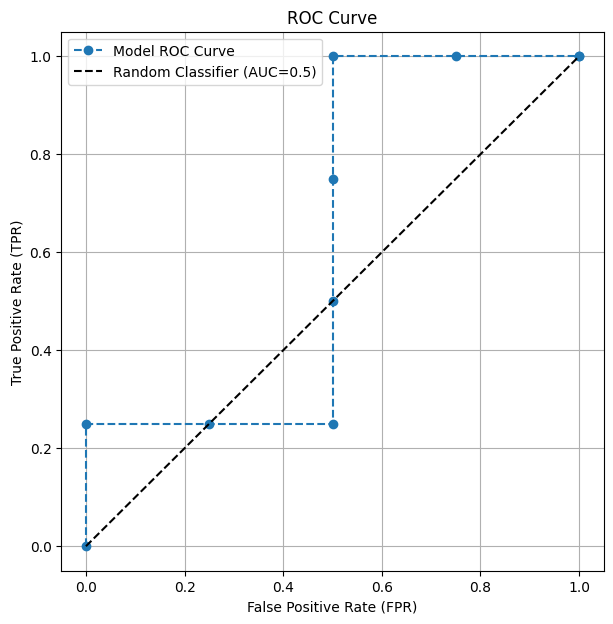

In [2]:
def calculate_roc_points(y_true, y_scores):
    """임계값 변화에 따른 TPR, FPR 리스트를 계산"""
    # 임계값을 y_scores를 기준으로 정렬하여 설정
    thresholds = np.sort(np.unique(y_scores))[::-1]
    
    tpr_list = []
    fpr_list = []
    
    # 각 임계값에 대해 TPR, FPR 계산
    for thresh in thresholds:
        # 현재 임계값보다 크면 1(Positive), 작으면 0(Negative)으로 예측
        y_pred = (y_scores >= thresh).astype(int)
        
        # 혼동 행렬 요소 계산
        TP = np.sum((y_true == 1) & (y_pred == 1))
        TN = np.sum((y_true == 0) & (y_pred == 0))
        FP = np.sum((y_true == 0) & (y_pred == 1))
        FN = np.sum((y_true == 1) & (y_pred == 0))
        
        # TPR, FPR 계산 (분모가 0이 되는 경우 방지)
        tpr = TP / (TP + FN) if (TP + FN) > 0 else 0
        fpr = FP / (FP + TN) if (FP + TN) > 0 else 0
        
        tpr_list.append(tpr)
        fpr_list.append(fpr)
        
    # 시작점 (0,0)과 끝점 (1,1)을 추가하여 완전한 곡선 생성
    return [0] + fpr_list + [1], [0] + tpr_list + [1]

# ROC 곡선 좌표 계산
fpr_points, tpr_points = calculate_roc_points(y_true, y_scores)

# ROC 곡선 시각화
plt.figure(figsize=(7, 7))
plt.plot(fpr_points, tpr_points, marker='o', linestyle='--', label='Model ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC=0.5)') # 무작위 분류기 선
plt.title('ROC Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.grid()
plt.legend()
plt.show()

### AUC (Area Under the Curve) 계산

AUC는 ROC 곡선 아래의 면적을 의미하며, 0에서 1 사이의 값을 가진다. 이 값은 모델의 전반적인 성능을 하나의 숫자로 요약해준다.

- **AUC = 1**: 완벽한 분류기. 모든 양성과 음성 샘플을 완벽하게 구별.
- **AUC = 0.5**: 무작위 분류기. 성능이 전혀 없음 (동전 던지기와 같음).
- **AUC > 0.5**: 분류 성능이 있음. 1에 가까울수록 성능이 우수.

AUC는 사다리꼴 공식을 사용하여 각 점 사이의 면적을 구해 더하는 방식으로 근사 계산할 수 있다.

In [4]:
# AUC 계산 (사다리꼴 넓이 공식 이용)
# auc = np.trapz(tpr_points, fpr_points)
auc = np.trapezoid(tpr_points, fpr_points)  # numpy의 trapezoid 함수 사용

print(f"계산된 AUC (Area Under the Curve): {auc:.4f}")

계산된 AUC (Area Under the Curve): 0.6250


### 최종 요약

ROC 곡선은 임계값 변화에 따른 분류 모델의 성능을 시각화하고, AUC는 그 성능을 단일 값으로 요약하여 모델 간의 성능을 객관적으로 비교하는 데 사용되는 강력한 평가지표이다.